In [1]:
from UTILITY_quickstart import *
?initializeTao

Signature:
initializeTao(
    filePath=None,
    lastTrackedElement='end',
    csrTF=False,
    inputBeamFilePathSuffix=None,
    numMacroParticles=None,
    loadDefaultLatticeTF=True,
    defaultsFile=None,
    runImpactTF=False,
    impactGridCount=32,
)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [2]:
tao = initializeTao(
    inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',

    csrTF = True,
    #numMacroParticles=1e4,
    #loadDefaultLatticeTF=False,
    lastTrackedElement="L0BFEND" #Initially, only want to load PInit. This is overriden in propagateToBEGBC20()

)

trackBeam(tao)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to L0BFEND
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles defined by input file


In [3]:
def propagateToBEGBC20(
    centerXYatBEGBC20 = False    
): 

    ##################################
    #Propagate to BEGBC20 and save result
    ##################################
    makeBeamActiveBeamFile(PInit)
    
    tao.cmd(f'set beam_init track_start = L0AFEND')
    lastTrackedElement = "BEGBC20"
    tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

    trackBeam(tao)

    P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

    ##################################
    #Optional!! Center in x and y
    ##################################
    if centerXYatBEGBC20:
        print(f"""Centering beam at BEGBC20, old values (x, xp, y, yp): {P["mean_x"]} ,{P["mean_xp"]}, {P["mean_y"]} ,{P["mean_yp"]} """)
        P.x = P.x - np.mean(P.x)
        P.y = P.y - np.mean(P.y)
        P.px = P.px - np.mean(P.px)
        P.py = P.py - np.mean(P.py)
    
    makeBeamActiveBeamFile(P)

    return

def prepareToSimulateFromBEGBC20toEnd():
    #####################################################
    #Import the BEGBC20 beam and prepare to simulate to end
    #####################################################

    tao.cmd(f'set beam_init track_start = BEGBC20')
    tao.cmd(f'set beam_init track_end = end')
    tao.cmd('reinit beam')

    return

In [4]:
#The reason for these extra steps (instead of just tracking to end) is because the optimizer uses propagateToBEGBC20(centerXYatBEGBC20 = True)

setLattice(tao)
propagateToBEGBC20(centerXYatBEGBC20 = True)
prepareToSimulateFromBEGBC20toEnd()
trackBeam(tao)

Centering beam at BEGBC20, old values (x, xp, y, yp): -5.0935983150468906e-05 ,-1.4408133038586503e-06, -2.8781246437999865e-07 ,3.107735382786306e-08 


In [5]:
savedData = {}

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)


for PActiveStr in ["PDrive", "PWitness"]:
    PActive = locals()[PActiveStr]
    for val in ["mean_x", "mean_y", "sigma_x", "sigma_y"]:
        savedData[f"{PActiveStr}_{val}"] = PActive[val]
        #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

    #Note that this is not a standard deviation; also imposes cost for being off zero
    savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
    savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


    #Using the product was making it report flat beams...
    #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
    #Instead, average
    savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:178: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [6]:
savedData

{'PDrive_mean_x': -9.332209288296808e-05,
 'PDrive_mean_y': -3.4775469187233355e-07,
 'PDrive_sigma_x': 2.5125583836547807e-05,
 'PDrive_sigma_y': 0.00020992841816578817,
 'PDrive_xCost': 9.66452688091078e-05,
 'PDrive_yCost': 0.00020992870620026153,
 'PDrive_totalCost': 0.00015328698750468467,
 'PDrive_emitSI90_x': 5.5059375836459233e-05,
 'PDrive_emitSI90_y': 1.9129174550772317e-05,
 'PDrive_zLen': 2.089852227334503e-05,
 'PDrive_zCentroid': 991.3317211084445,
 'PWitness_mean_x': -9.195496855099973e-05,
 'PWitness_mean_y': -9.215092698814656e-07,
 'PWitness_sigma_x': 2.3849157071779382e-05,
 'PWitness_sigma_y': 0.00013637006035161885,
 'PWitness_xCost': 9.499736066991415e-05,
 'PWitness_yCost': 0.00013637317382696144,
 'PWitness_totalCost': 0.00011568526724843779,
 'PWitness_emitSI90_x': 2.4048506853813624e-05,
 'PWitness_emitSI90_y': 3.6010388439518112e-06,
 'PWitness_zLen': 7.766677704681586e-06,
 'PWitness_zCentroid': 991.3318278688581,
 'bunchSpacing': 0.000106760413586926}

In [7]:
print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")

print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2) :.3g} um""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_z: \t{1e6 * savedData["PDrive_zLen"] :.3g} um""")
print(f"""Witness sigma_z: \t{1e6 * savedData["PWitness_zLen"] :.3g} um""")

Bunch spacing: 		107 um
Transverse offset: 	1.48 um

Emittances and sigmas - implied by 90% charge
Driver emittance: 	55.1 × 19.1 um-rad
Witness emittance: 	24 × 3.6 um-rad
Driver sigma_z: 	20.9 um
Witness sigma_z: 	7.77 um


In [8]:
print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g}, {1e6 * PWitness["sigma_y"] :.3g}, {1e6 * PWitness["sigma_z"] :.3g} um""")


Emittances and sigmas - literal standard deviation
Driver emittance: 	63.6 × 46.7 um-rad
Witness emittance: 	29.4 × 7.93 um-rad
Driver sigma_x,y,z: 	25.1, 210, 25.9 um
Witness sigma_x,y,z: 	23.8, 136, 7.79 um


Drive:


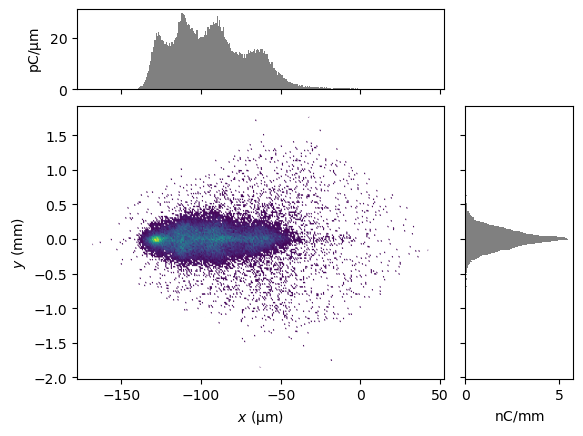

Witness:


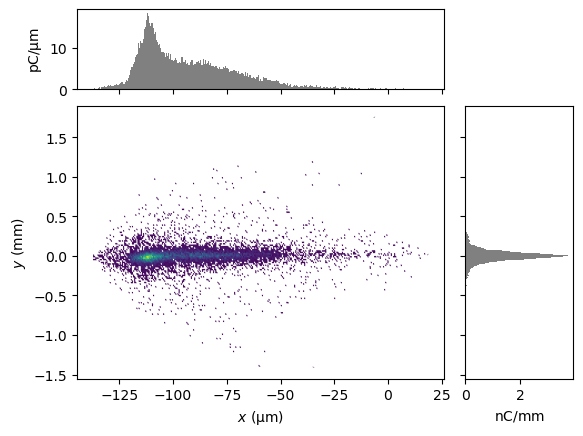

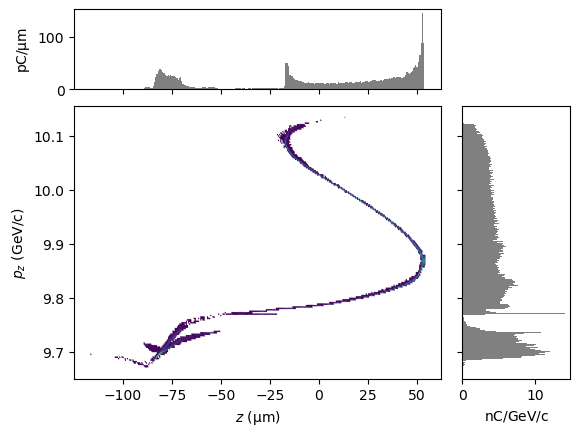

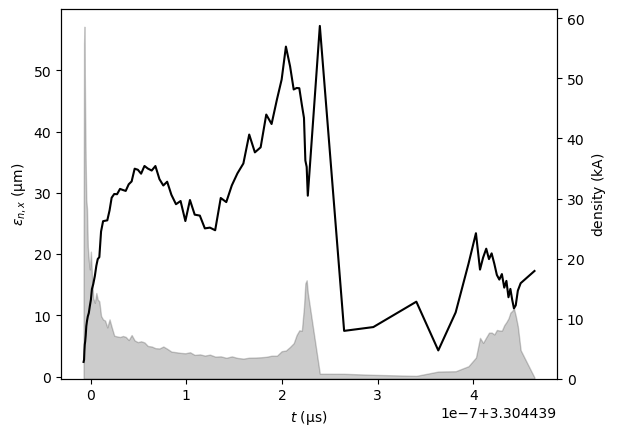

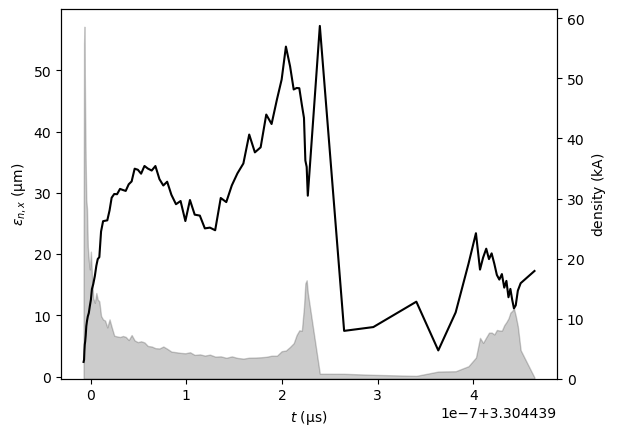

In [9]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
print("Witness:")
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
#display(slicePlotMod(P, 'norm_emit_x', slice_key = "z", n_slice=100))
display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))

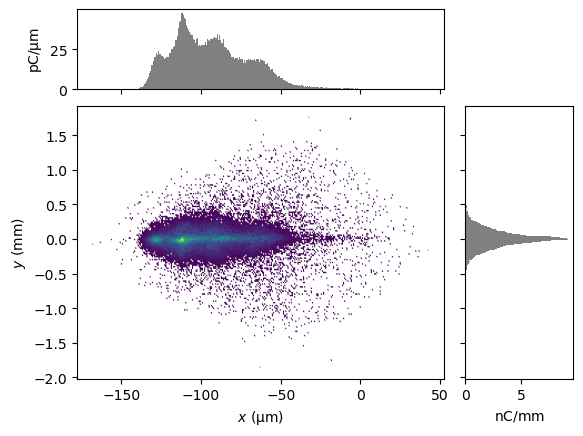

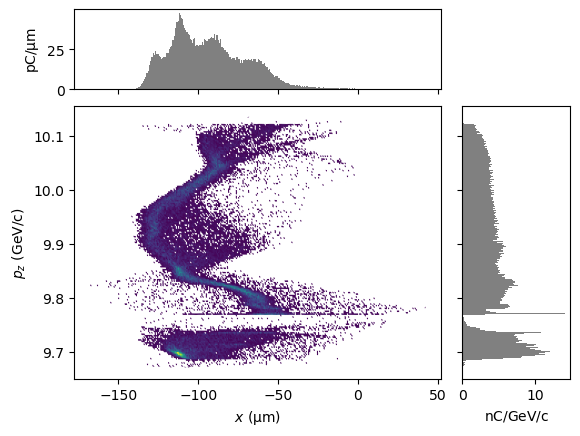

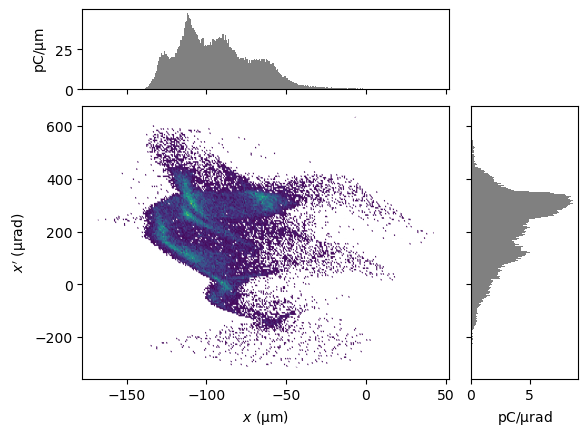

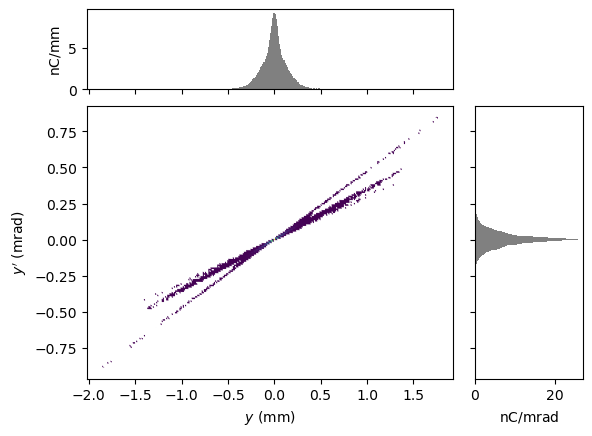

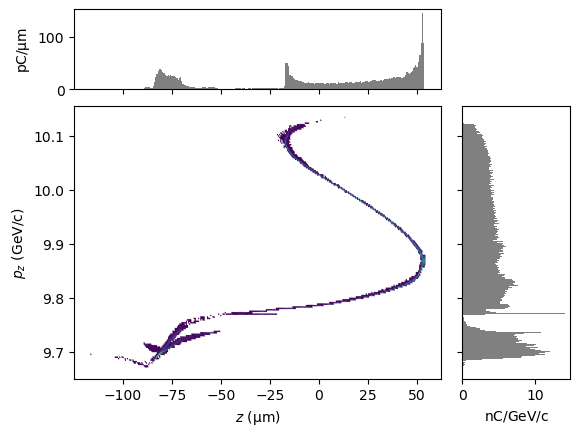

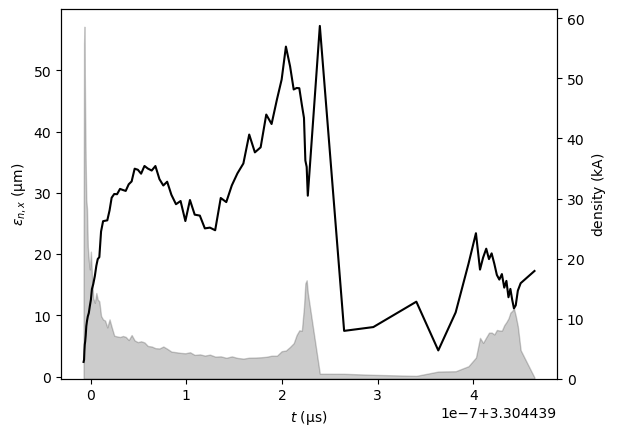

In [10]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))

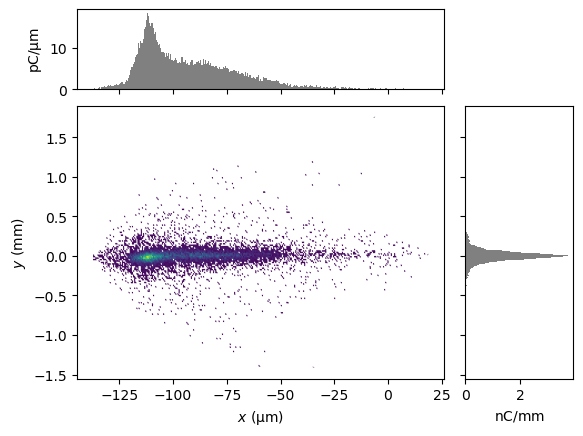

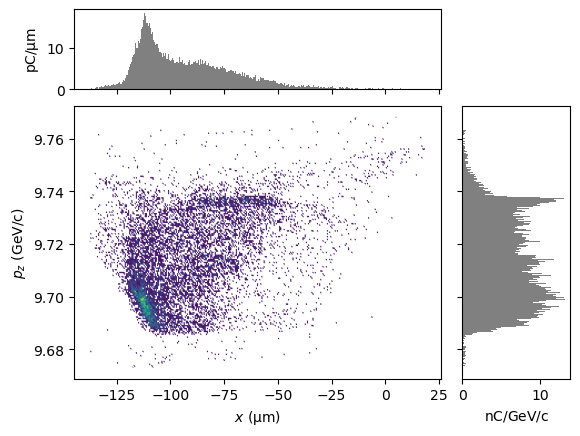

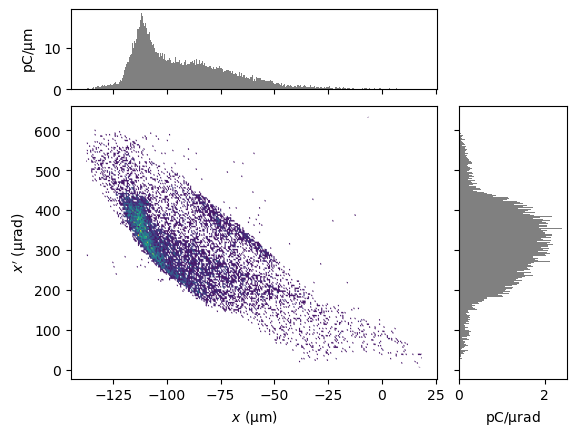

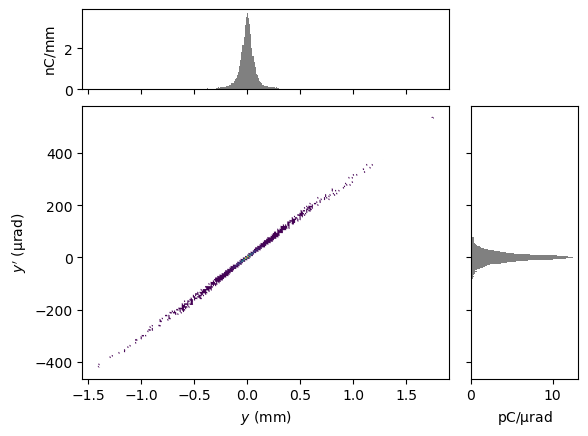

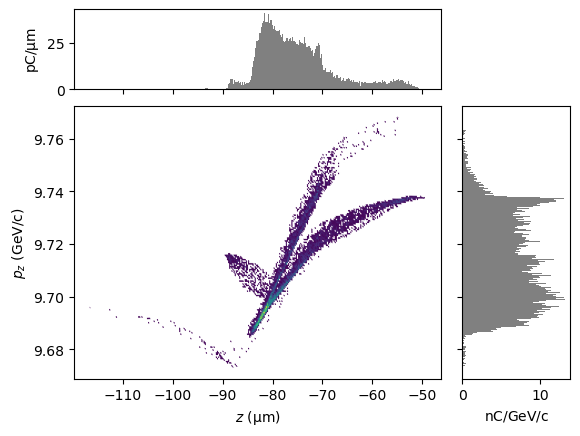

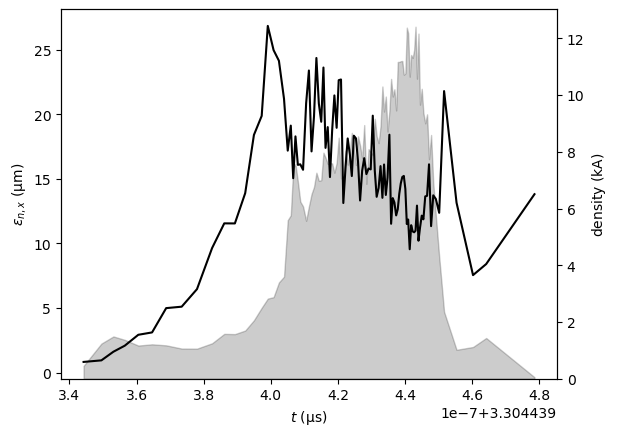

In [11]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'z', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


P, sigma x: 2.483584901883339e-05
PDrive, sigma x: 2.5125583836547807e-05
PWitness, sigma x: 2.3849157071779382e-05


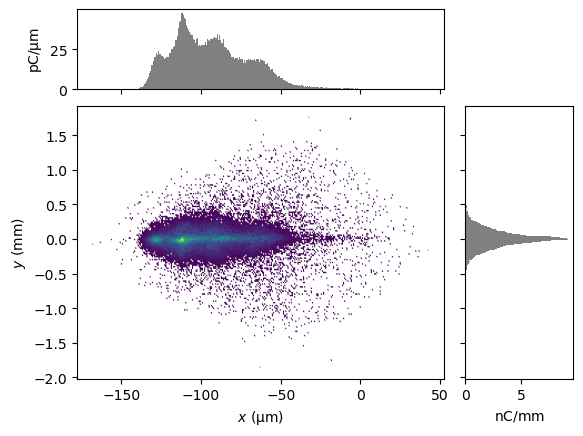

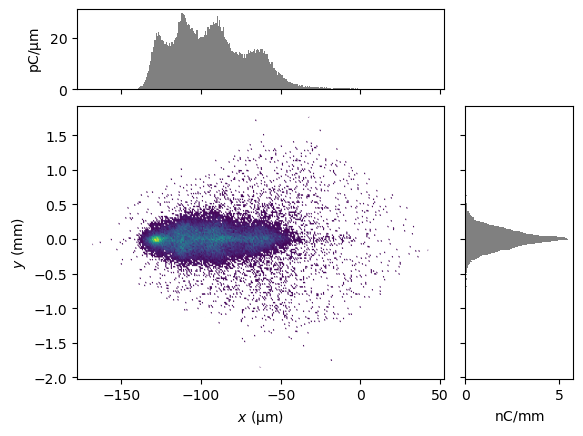

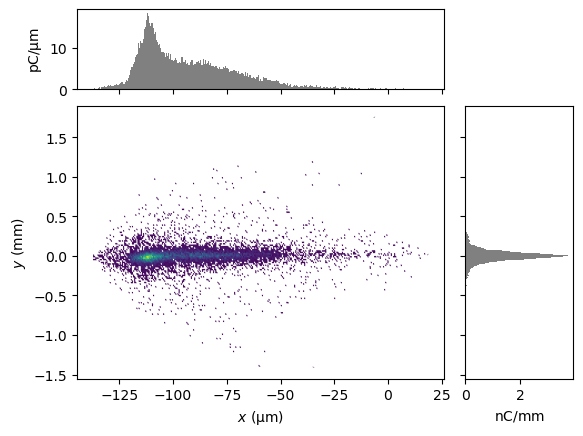

In [12]:
print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'y',  bins=300))

In [13]:
P.drift_to_z

<bound method ParticleGroup.drift_to_z of <ParticleGroup with 100000 particles at 0x1070e3250>>

In [14]:
PTmp = ParticleGroup.drift_to_z(P)

In [15]:
?ParticleGroup.drift_to_z

Signature: ParticleGroup.drift_to_z(self, z=None)
Docstring: <no docstring>
File:      /opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/pmd_beamphysics/particles.py
Type:      function

## BEGBC20

In [16]:
# savedData = {}

# P = getBeamAtElement(tao, "BEGBC20")
# PDrive, PWitness = getDriverAndWitness(P)


# for PActiveStr in ["PDrive", "PWitness"]:
#     PActive = locals()[PActiveStr]
#     for val in ["mean_x", "mean_y", "sigma_x", "sigma_y"]:
#         savedData[f"{PActiveStr}_{val}"] = PActive[val]
#         #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

#     #Note that this is not a standard deviation; also imposes cost for being off zero
#     savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
#     savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


#     #Using the product was making it report flat beams...
#     #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
#     #Instead, average
#     savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

#     savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
#     savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

#     savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

#     savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

# savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

# savedData